# EE 25614: Neuroscience of Learning, Memory, & Cognition
## Fall 2018
## PyTorch Tutorial Assignment
### Deadline: November 2, 2018

### Name: 
### Student ID:


In this assignment, you are tasked with implementing and training a simple recurrent neural network model using PyTorch. You will use this network to solve two tasks.



These are the steps you should take to complete this assignment:
1. Implement VanillaRNN class.
2. Train the network with the datasets you have generated. Visualize how loss changes through epochs.
4. Retrain the data using different sets of parameters. Report and visualize how changing each parameter changes loss. These parameters include:
    - Learning rate
    - Hidden layer size
    - Batch size
    - Number of Epochs
5. Report the parameters of your best network. Run the network on test data and visualize some examples of denoised signals the network makes.
6. Visualize activity of specific neurons through time as they process data in the parity task. Set hidden layer size to a small number for better visuals.

After completing the assignment, upload this notebook in a zip file with your student ID as its name on the CW website.

You should write all of the codes by yourself. Copying codes that are available on the internet or your classmates have written is prohibited.

If you have any questions about this assignment, please ask them on Piazza.

# Part 0: Generating datasets for two tasks.
You should write code that generates training and test datasets for each of the tasks below.


## Task 1: Predicting parity bit of a bit vector

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

def parity_generator(N,L):
    X = np.random.randint(0,2,(N,L))
    Y = np.zeros((N,L))
    for i in range (L):
        Y[:,i] = np.sum(X[:,0:i+1],1)%2
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).double()
    return X, Y

# testing the generator
N = 1000
L = 10
X, Y = parity_generator(N,L)
print(X[0,:])
print(Y[0,:])


tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.], dtype=torch.float64)


## Task 2: Predicting a denoised sine wave from a noisy signal



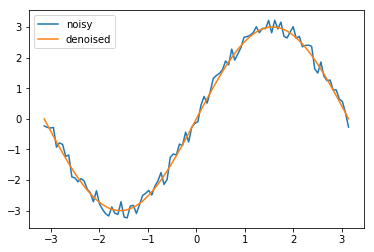

In [3]:
import matplotlib.pylab as plt


def sine_generator(N,L):
    X = np.zeros((N,L))
    Y = np.zeros((N,L))
    x = np.linspace(-np.pi, np.pi, L)
    amplitude = np.random.randn(N,1) * np.ones((N,L))
    amplitude = np.ones((N,L))*np.random.randint(1, 4, size=(N,1))
    #Y = 10*np.sin(x)*amplitude
    Y = np.sin(x)*amplitude
    X = Y + np.random.uniform(-0.3, 0.3, size=Y.shape)


    return X, Y


# testing the generator
x = np.linspace(-np.pi, np.pi, L)
N = 1000
L=100
X, Y = sine_generator(N,L)

plt.plot(x,np.array(X[120,:]), label = 'noisy')
plt.plot(x,np.array(Y[120,:]), label = 'denoised')
plt.legend()
plt.show()


# Part 1: Vanilla RNN

Equations of a forward pass in a simple RNN network looks like this:

$s_{t}=f(Ux_{t}+b_{U}+Ws_{t-1}+b_{W})$

$o_{t}=f'(Vs_{t}+b_{V})$

Where:

$s_{t}$: Hidden state of RNN at time step t.

$x_{t}$: Input at time step t.

$U$: Learnable weight matrix for connections between the hidden state and input.

$W$: Learnable weight matrix for connections between the hidden states.

$V$: Learnable weight matrix for connections between the hidden state and output.

$o_{t}$: Output at time step t.

$f$ and $f'$: Nonlineartiy functions such as tanh, ReLU, & Softmax

$b_{U}$, $b_{W}$, and $b_{V}$: Bias terms

We talked what the bias term does in the class. In practice, bias terms are not held separately. Using the bias trick, we can store $W$ and bias term of a linear model $y=Wx+b$ in a single matrix. 
![The bias trick](../media/wb.jpg)
Using the bias trick, the equations of RNN are reduce to the following:

$s_{t}=f(Ux_{t}+Ws_{t-1})$

$o_{t}=f'(Vs_{t})$

PyTorch's $nn$ module has a function for a linear models such as $y=Wx+b$. Set $f$ and $f'$ to to *tanh*.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.NonlinearFunc = nn.Tanh()
    
    def forward(self, input, hidden):
        hidden = self.input2hidden(input) + self.hidden2hidden(hidden)
        output = self.NonlinearFunc(self.hidden2output(hidden))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
    
#params = list(rnn.parameters())
#print(len(params))
#print(params[0].size())


In [44]:
input_dim = 1
hidden_size = 30
num_layers = 1

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
        self.hidden2output = nn.Linear(hidden_size, output_size, )
        
        self.NonlinearFunc = nn.Tanh()
        
        
    def forward(self, x):
        output, hidden = self.rnn(x, None)
        
        output = self.NonlinearFunc(self.hidden2output(output)).view(output.data.shape[0], -1, 1)
        
        return output

r= RNN2(input_dim, hidden_size, 1)

In [211]:
def predictor(output):
    return (output>0.5).double()    
hidden_size = 4
rnn = RNN(input_size=1, hidden_size=hidden_size, output_size=1)
number_of_epochs = 1000
L = 10
N = 100
batch_size = 50
num_of_batches = int(N/batch_size)
print(num_of_batches)
input, target = parity_generator(N,L)
print(input.size())
for epochs in range(number_of_epochs):
    criterion = nn.MSELoss()

    learning_rate = 0.005

    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
  #  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    
    
    OUT = torch.tensor(np.zeros((batch_size, L)))

    rnn.zero_grad()
    
    for k in range (num_of_batches):
        for i in range (batch_size):
            hidden = rnn.init_hidden()
            for j in range (L):
                output, hidden = rnn(input[k*batch_size+i,j].unsqueeze(0), hidden)
                OUT[i,j] = output
                #loss += criterion(output.double(), target[k*batch_size+i,j].unsqueeze(0).unsqueeze(0))
    loss = criterion(OUT.double(), target[k*batch_size:(k+1)*batch_size,:])
    loss.backward()
    optimizer.step()
    
    if (epochs%50==0):
        print(epochs)
        print('loss=',loss)
OUTPUT = predictor(OUT)
E = abs(OUTPUT-target[k*batch_size:(k+1)*batch_size,:])
print(OUT)
print(target[k*batch_size:(k+1)*batch_size,:])
print(E)
true_percentage = 100*(1-torch.sum(E)/(batch_size*L))
print(true_percentage)
print(hidden, hidden.size())

        #return output, loss.data[0]

2
torch.Size([100, 10])
0
loss= tensor(0.5943, dtype=torch.float64, grad_fn=<MseLossBackward>)
50
loss= tensor(0.2771, dtype=torch.float64, grad_fn=<MseLossBackward>)
100
loss= tensor(0.2537, dtype=torch.float64, grad_fn=<MseLossBackward>)
150
loss= tensor(0.2497, dtype=torch.float64, grad_fn=<MseLossBackward>)
200
loss= tensor(0.2486, dtype=torch.float64, grad_fn=<MseLossBackward>)
250
loss= tensor(0.2480, dtype=torch.float64, grad_fn=<MseLossBackward>)
300
loss= tensor(0.2476, dtype=torch.float64, grad_fn=<MseLossBackward>)
350
loss= tensor(0.2472, dtype=torch.float64, grad_fn=<MseLossBackward>)
400
loss= tensor(0.2469, dtype=torch.float64, grad_fn=<MseLossBackward>)
450
loss= tensor(0.2467, dtype=torch.float64, grad_fn=<MseLossBackward>)
500
loss= tensor(0.2465, dtype=torch.float64, grad_fn=<MseLossBackward>)
550
loss= tensor(0.2463, dtype=torch.float64, grad_fn=<MseLossBackward>)
600
loss= tensor(0.2461, dtype=torch.float64, grad_fn=<MseLossBackward>)
650
loss= tensor(0.2460, dtype

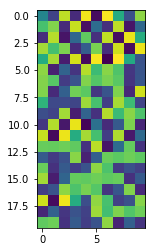

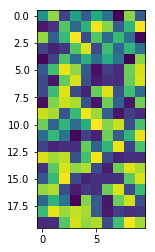

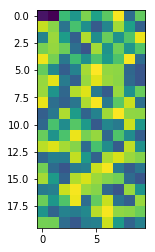

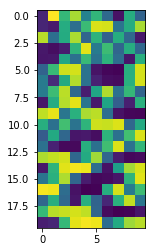

tensor([[1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 1., 1., 0., 1.],
        [1., 0., 1., 1., 1., 0., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.]],

In [192]:
import matplotlib.pylab as plt
number_of_epochs = 1000
number_of_tests = 20
input, target = parity_generator(number_of_tests,L)

hidden = rnn.init_hidden()
O = torch.tensor(np.zeros(L))
Hidden = torch.tensor(np.zeros((L,hidden_size,number_of_tests)))
for test in range (number_of_tests):
    for i in range (L):
        rnn.zero_grad()
        output, hidden = rnn(input[test,i].unsqueeze(0), hidden)
        Hidden[i,:,test] = hidden
        O[i] = output
for unit in range(hidden_size):
    Hid = np.array(Hidden[:,unit,:].detach().numpy())
    plt.figure
    plt.imshow(Hid.T)
    plt.show()
#print(loss)
OUTPUT = predictor(O)
E = abs(OUTPUT-target)
print(E)
#print(OUTPUT)
print(1-torch.sum(E)/(L*number_of_tests))
#print((((predictor(O)).float()-(target==1).float)))
#print(.sum().float()/L)

        #return output, loss.data[0]

In [ ]:
L = 100
rnn = RNN(input_size=L, hidden_size=5, output_size=L)
number_of_epochs = 1000

N = 1000
batch_size = 20
num_of_batches = int(N/batch_size)
print(num_of_batches)
input, target = sine_generator(N,L)
input = torch.tensor(input)
target = torch.tensor(target)
print(input.size())
for epochs in range(number_of_epochs):
    criterion = nn.L1Loss()

    learning_rate = 0.001

    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
  #  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    
    OUT = torch.tensor(np.zeros((batch_size, L)))

    rnn.zero_grad()
    
    for k in range (num_of_batches):
        for i in range (batch_size):
            hidden = rnn.init_hidden()
            output, hidden = rnn(input[k*batch_size+i,:].float().unsqueeze(0), hidden.float())
            OUT[i,:] = output
                #loss += criterion(output.double(), target[k*batch_size+i,j].unsqueeze(0).unsqueeze(0))
    loss = criterion(OUT.double(), target[k*batch_size:(k+1)*batch_size,:])
    loss.backward()
    optimizer.step()
    
    if (epochs%50==0):
        print(epochs)
        print('loss=',loss)
plt.figure
plt.plot(OUT.detach().numpy()[-1,:],label='out')
plt.plot(input.detach().numpy()[-1,:],label='in')
plt.plot(target.detach().numpy()[-1,:],label='target')
plt.legend()
plt.show


50
torch.Size([1000, 100])
0
loss= tensor(1.4982, dtype=torch.float64, grad_fn=<L1LossBackward>)
50
loss= tensor(1.4795, dtype=torch.float64, grad_fn=<L1LossBackward>)
100
loss= tensor(1.4640, dtype=torch.float64, grad_fn=<L1LossBackward>)
150
loss= tensor(1.4510, dtype=torch.float64, grad_fn=<L1LossBackward>)
200
loss= tensor(1.4419, dtype=torch.float64, grad_fn=<L1LossBackward>)
250
loss= tensor(1.4343, dtype=torch.float64, grad_fn=<L1LossBackward>)
300
loss= tensor(1.4270, dtype=torch.float64, grad_fn=<L1LossBackward>)
350
loss= tensor(1.4198, dtype=torch.float64, grad_fn=<L1LossBackward>)
400
loss= tensor(1.4134, dtype=torch.float64, grad_fn=<L1LossBackward>)
450
loss= tensor(1.4070, dtype=torch.float64, grad_fn=<L1LossBackward>)
500
loss= tensor(1.4015, dtype=torch.float64, grad_fn=<L1LossBackward>)
550
loss= tensor(1.3962, dtype=torch.float64, grad_fn=<L1LossBackward>)
600
loss= tensor(1.3922, dtype=torch.float64, grad_fn=<L1LossBackward>)
650
loss= tensor(1.3896, dtype=torch.flo

In [ ]:
hidden_size = 4
rnn = RNN(input_size=1, hidden_size=hidden_size, output_size=1)
number_of_epochs = 1000
L = 50
N = 100
batch_size = 50
num_of_batches = int(N/batch_size)
print(num_of_batches)
input, target = sine_generator(N,L)
input = torch.tensor(input)
target = torch.tensor(target)
print(input.size())

for epochs in range(number_of_epochs):
    criterion = nn.MSELoss()

    learning_rate = 0.005

    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
  #  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    
    
    OUT = torch.tensor(np.zeros((batch_size, L)))

    rnn.zero_grad()
    
    for k in range (num_of_batches):
        for i in range (batch_size):
            hidden = rnn.init_hidden()
            for j in range (L):
                output, hidden = rnn(input[k*batch_size+i,j].float().unsqueeze(0), hidden.float())
                OUT[i,j] = output
                #loss += criterion(output.double(), target[k*batch_size+i,j].unsqueeze(0).unsqueeze(0))
    loss = criterion(OUT.double(), target[k*batch_size:(k+1)*batch_size,:])
    loss.backward()
    optimizer.step()
    
    if (epochs%50==0):
        print(epochs)
        print('loss=',loss)

plt.figure
plt.plot(OUT.detach().numpy()[-1,:],label='out')
plt.plot(input.detach().numpy()[-1,:],label='in')
plt.plot(target.detach().numpy()[-1,:],label='target')
plt.legend()
plt.show

2
torch.Size([100, 50])
0
loss= tensor(4.4454, dtype=torch.float64, grad_fn=<MseLossBackward>)
50
loss= tensor(1.4644, dtype=torch.float64, grad_fn=<MseLossBackward>)
100
loss= tensor(0.8042, dtype=torch.float64, grad_fn=<MseLossBackward>)
150
loss= tensor(0.6956, dtype=torch.float64, grad_fn=<MseLossBackward>)
200
loss= tensor(0.6679, dtype=torch.float64, grad_fn=<MseLossBackward>)
250
loss= tensor(0.6588, dtype=torch.float64, grad_fn=<MseLossBackward>)
300
loss= tensor(0.6551, dtype=torch.float64, grad_fn=<MseLossBackward>)
350
loss= tensor(0.6532, dtype=torch.float64, grad_fn=<MseLossBackward>)
400
loss= tensor(0.6522, dtype=torch.float64, grad_fn=<MseLossBackward>)
450
loss= tensor(0.6514, dtype=torch.float64, grad_fn=<MseLossBackward>)


In [74]:
# Storing predictions per iterations to visualise later
torch.set_default_tensor_type('torch.FloatTensor')

predictions = []
#r = RNN2

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

input, target = sine_generator(N,L)
input = (np.array(input, dtype=np.float32))

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(input.reshape((input.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(target.reshape((target.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

TypeError: expected torch.FloatTensor (got torch.DoubleTensor)

In [84]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [88]:
input_dim = 1
hidden_size = 30
num_layers = 1

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.hidden2output = nn.Linear(hidden_size, output_size, )
        self.NonlinearFunc = nn.Tanh()
    def forward(self, x):
        output, hidden = self.rnn(x, None)
        output = self.NonlinearFunc(self.hidden2output(output)).view(output.data.shape[0], -1, 1)
        return output

r= RNN2(input_dim, hidden_size, 1)

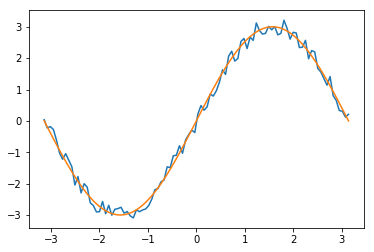

In [152]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = np.random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out




In [81]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

In [82]:
data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [153]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()
train_inp, train_out = sine_generator(10000,100)
for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

/home/amirhossein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


0 tensor(0.5313)
20 tensor(0.5311)
40 tensor(0.5235)
60 tensor(0.5183)
80 tensor(0.5154)
100 tensor(0.5139)
120 tensor(0.5136)
140 tensor(0.5129)
160 tensor(0.5116)
180 tensor(0.5130)
200 tensor(0.5086)
220 tensor(0.5361)
240 tensor(0.5166)
260 tensor(0.5131)
280 tensor(0.5132)
300 tensor(0.5099)


tensor(0.1062)


/home/amirhossein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Sample num: 23')

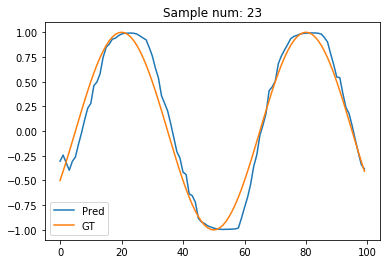

In [156]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))